## Homework 4: Mean Shift Segmentation

**Due date:** May 4, 2023

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [1200]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.color import rgb2lab,lab2rgb
import random
import cv2
import matplotlib.pyplot as plt
from time import time
from skimage import io, color

**Part 1: mean shift on synthetic data**

Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.

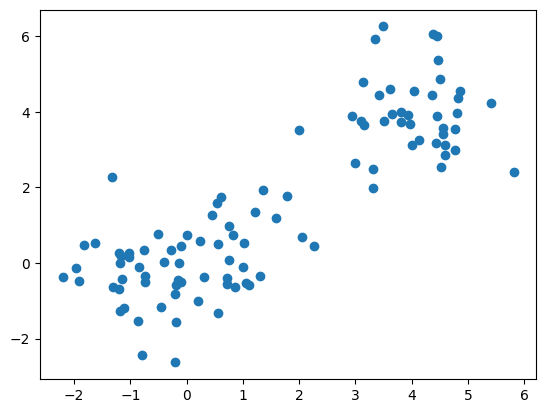

In [1201]:
max_iter = 1000

# generating the synthetic dataset
mean1 = np.zeros(2)
cov1 = np.eye(2) # unit covariance, np.eye: return a 2d array with ones on the diagonal and zeros elsewhere
mean2 = np.array([4, 4]) 
cov2 = np.eye(2) # unit covariance
# draw random samples from a multivariate normal distribution
data1 = np.random.multivariate_normal(mean1, cov1, size = 60) # 60 points sampled from a Gaussian distribution of unit covariance centered in (0, 0)   
data2 = np.random.multivariate_normal(mean2, cov2, size = 40) # 40 points sampled from a Gaussian with unit covariance centered in (4, 4)
data = np.vstack([data1, data2])

# visualizing the dataset
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.

computer vision, ponce p.274
\begin{align*}
K(x, h) &= \frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\frac{\partial K(x, h)}{\partial x} &= \left(-\frac{1}{2}\frac{2\|x\|}{h}\right)\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
&= -\frac{\|x\|}{h}\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\end{align*}

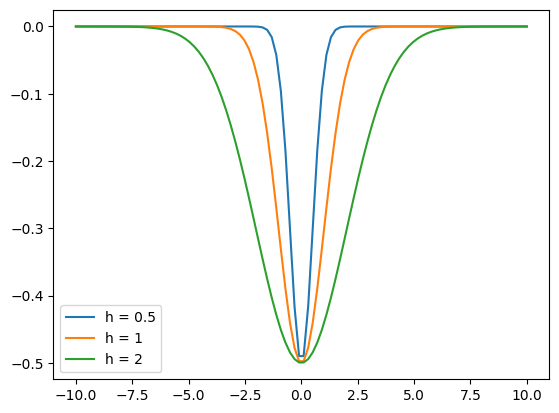

In [1202]:
def gaussian_kernel_function(r): # Fukunaga 1975, p.30
    return math.exp(-0.5 * r)
    
def epanechnikov_kernel_function(r): # Fukunaga 1975, p.30
    return 0.75 * (1 - r)

def gaussian_kernel_first_derivative(r):
    return -0.5 * math.exp(-0.5 * r)

def derivative(r):
    if r > 1: return 0
    else: return 1

def kernel(x, h, derivative = "gaussian"):
    norm_x = np.linalg.norm(x) ** 2 / h ** 2
    if derivative == "gaussian":
        g = gaussian_kernel_first_derivative(norm_x)
        # g = -2 * np.exp(-0.5 * norm_x) / (np.sqrt(2 * np.pi) * h ** 3)
    elif derivative == "epanechnikov":
        if norm_x < 1:
            g = epanechnikov_kernel_function(norm_x)
            # g = 3 / (4 * np.pi * h ** 5) * (1 - norm_x)
        else:
            g = 0
    return g

x_range = np.linspace(-10, 10, 100)
h_values = [0.5, 1, 2]

for h in h_values:
    g_values = [kernel(np.array([x]), h) for x in x_range]
    plt.plot(x_range, g_values, label = f"h = {h}")
plt.legend()
plt.show()

In [1203]:
class MeanShift:
    def __init__(self, spacial_threshold=2.0, range_threshold=10.0, max_iter=20, kernel='guassian',min_region_size=5):
        self.__spacial_threshold = spacial_threshold
        self.__range_threshold = range_threshold
        self.__max_iter = max_iter
        self.__min_region_size = min_region_size
        if kernel == 'gaussian':
            self.__kernel_function = self.__gaussian_kernel_function
        else:
            self.__kernel_function = self.__epanechnikov_kernel_function

Implement a function `MS_step` that takes as input a starting point `x`,
a set of data points `data`, and a bandwidth `h` and returns the updated position
of the point `x` after one step of the mean-shift algorithm.

In [1204]:
class MeanShift(MeanShift):
    # Define a step of the mean shift algorithm for a single data point x, with kernel size h
    def MS_step(self, data, x, h):
        shift = np.zeros_like(x)  # Initialize shift to zero vector
        weight_sum = 0.0  # Initialize weight sum to zero
        # Loop over all data points to compute their influence on the shift vector
        for point in data:
            weight = self.__derivative(self.__kernel_function((x - point) / h))  # Compute weight based on kernel function
            shift = shift + (point * weight)  # Add contribution of point to shift
            weight_sum += weight  # Add weight to the sum
        # If all weights are zero, return the original point
        if weight_sum == 0.0:
            return x
        # Otherwise, compute the new mean shift vector and return it as integer values
        else:
            return (shift / weight_sum).astype('int')
    
    # Define Gaussian kernel function
    def __gaussian_kernel_function(self, x):
        return math.exp(-0.5*np.sum(x**2))
    
    # Define Epanechnikov kernel function
    def __epanechnikov_kernel_function(self, x):
        return 0.75*(1-np.sum(x**2))
    
    # Define derivative of the kernel function
    def __derivative(self, x):
        if x > 1:  # If x is greater than 1, return 0
            return 0
        else:  # Otherwise, return 1
            return 1
    
    # Define Euclidean distance function
    def __euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a-b)**2))

Implement the function `MS_point` which iterates `MS_step` until convergence
(i.e., when the estimate changes by less than a small constant).
Test it on your synthetic data and visualize the results.

In [1205]:
class MeanShift(MeanShift):
    def MS_point(self, image_points, bandwidth):
        # Take the first point as the initial centroid
        first_point = image_points[0]
        last_centroid = first_point
        iteration = 0
        while iteration < self.__max_iter:  # Repeat until convergence or maximum iteration
            iteration += 1
            # Update centroid by calculating the shift from the last centroid
            centroid = self.MS_step(image_points, last_centroid, bandwidth)
            # Calculate the distance between the last centroid and the new centroid
            distance = self.__euclidean_distance(last_centroid, centroid)
            # Break the loop if the distance between the centroids is less than the range threshold or
            # if the centroid is the same as the last one (i.e., convergence)
            if distance < self.__range_threshold or np.all(centroid == last_centroid):
                break
            last_centroid = centroid  # Update the last centroid to the current centroid
        return centroid  # Return the final centroid

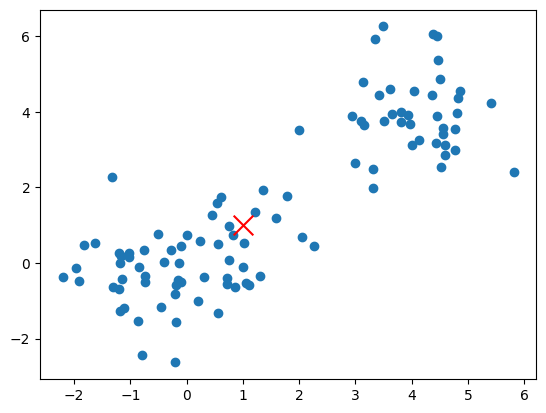

In [1206]:
ms_object1 = MeanShift(spacial_threshold=3,range_threshold=20,kernel="epanechnikov")
c = ms_object1.MS_point(data, 20)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(c[0], c[1], marker = "x", s = 200, color = "red")
plt.show()

In [1207]:
class MeanShift(MeanShift):    
    def __getPixelWindow(self, random_pixel_id, pixels_to_process):
    # Get the coordinates of the random pixel from the image vector
        random_pixel = self.__image_vector[random_pixel_id]
        
        # Get the x and y coordinates of the random pixel
        random_pixel_x = random_pixel[0]
        random_pixel_y = random_pixel[1]
        
        # Set the left, right, top, and bottom limits of the frame
        left_limit = int(random_pixel_x - self.__spacial_threshold)
        right_limit = int(random_pixel_x + self.__spacial_threshold)
        top_limit = int(random_pixel_y - self.__spacial_threshold)
        bottom_limit = int(random_pixel_y + self.__spacial_threshold)
        
        # Ensure that the limits of the frame do not exceed the image bounds
        if left_limit < 0:
            left_limit = 0
        if right_limit > self.__auxillary_grid.shape[0]:
            right_limit = self.__auxillary_grid.shape[0]
        if top_limit < 0:
            top_limit = 0
        if bottom_limit > self.__auxillary_grid.shape[1]:
            bottom_limit = self.__auxillary_grid.shape[1]
        
        # Extract the frame from the auxiliary grid
        frame = self.__auxillary_grid[left_limit:right_limit, top_limit:bottom_limit]
        
        # Flatten the frame
        frame = frame.ravel()
        
        # Filter out pixels that should not be processed
        nframe = []
        for pixel_id in frame:
            if pixel_id == random_pixel_id or pixel_id not in pixels_to_process:
                continue
            nframe.append(pixel_id)
        frame = np.array(nframe)

        # If the frame is empty, return the random pixel as an array
        if frame.size ==0:
            return np.array([random_pixel])
        # Subtract the color values of the random pixel from the frame pixels
        #print "Frame Ravel: ",frame
        frame_pixel_values = self.__image_vector[frame][:,2:]
        #print "Frame Values: ",frame_pixel_values
        frame_pixel_values -= random_pixel[2:]
        # Square the pixel color value differences
        #print "After Subtraction: ", frame_pixel_values
        frame_pixel_values **=2
        # Compute the Euclidean distances between the pixels in the frame and the random pixel
        frame_pixel_distances = np.sqrt(np.sum(frame_pixel_values, axis=1))
         # Filter out pixels that are too far from the random pixel
        frame = frame[frame_pixel_distances <= self.__range_threshold]
        # Remove processed pixels from the set of pixels to process
        #print "Distances: ", frame_pixel_distances
        for pixel_id in frame:
            pixels_to_process.pop(pixel_id)
        # If the filtered frame is empty, return the random pixel as an array
        if frame.size ==0:
            return np.array([random_pixel])
        # Return the filtered frame and the random pixel as a vertically stacked array
        return np.vstack([self.__image_vector[frame], random_pixel])
    
    def __getWindowValues(self, window):
        # extract the pixel values from the window and return them
        return window[:,2:]

    def __regionsToImage(self,image,regions):
        # create an empty array with the same shape as the input image
        result = np.empty_like(image)
        # loop through each region and set the pixel values in the result array to the pixel values of the region
        for region in regions:
            for pixel in region:
                result[int(pixel[0]),int(pixel[1])] = pixel[2:]
        # return the result array
        return result

    def __getCentroidWindow(self, lookup_matrix, centroid, visited, spatial_centroids, range_centroids):
        # calculate the limits of the window around the centroid
        left_limit = centroid[0] - self.__spacial_threshold
        right_limit = centroid[0] + self.__spacial_threshold +1
        top_limit = centroid[1] - self.__spacial_threshold
        bottom_limit = centroid[1] + self.__spacial_threshold +1
        # ensure the limits are within the bounds of the lookup matrix
        if left_limit < 0:
            left_limit = 0
        if right_limit > self.__auxillary_grid.shape[0]:
            right_limit = self.__auxillary_grid.shape[0]
        if top_limit < 0:
            top_limit = 0
        if bottom_limit > self.__auxillary_grid.shape[1]:
            bottom_limit = self.__auxillary_grid.shape[1]
        result = []
        centroid_region = lookup_matrix[centroid[0],centroid[1]]
        # loop through each pixel in the window and check if it is within range of the centroid
        for i in range(left_limit, right_limit):
            for j in range(top_limit, bottom_limit):
                if lookup_matrix[i,j] != 0 and lookup_matrix[i,j] not in visited:
                    if self.__euclidean_distance(range_centroids[centroid_region], range_centroids[lookup_matrix[i,j]]) < self.__range_threshold:
                        result.append(lookup_matrix[i,j])
        # return the list of pixels within range of the centroid
        return result

    def __overlayBorders(self, image):
        # detect edges using the Canny edge detection algorithm
        edges = cv2.Canny(image, 20, 240)
        # overlay the edges onto the original image using alpha blending
        return cv2.addWeighted(image, 1.0, np.dstack((edges,edges,edges)), 1.0,0)

Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.

In [1208]:
class MeanShift(MeanShift):
    def _mean_shift(self, data, bandwidth):
        # Initialize empty list to store modes and labels
        modes = []
        labels = np.zeros(len(data), dtype=np.int)
        
        # Loop over all points in the data
        for i, x in enumerate(data):
            # If the point has not already been labeled, find its mode
            if labels[i] == 0:
                mode = self.MS_point(data, bandwidth)
                modes.append(mode)
                
                # Assign all nearby points to this mode
                for j, y in enumerate(data):
                    # if self.__euclidean_distance(mode, y) < bandwidth * 0.5:
                    if self.__euclidean_distance(mode, y) < self.__range_threshold:
                        labels[j] = len(modes)
        
        return modes, labels

c:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


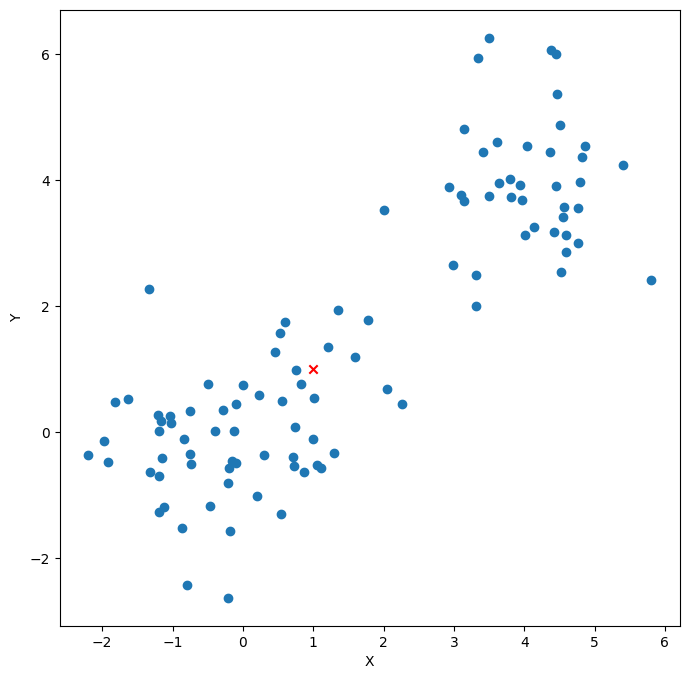

In [1209]:
ms_obj = MeanShift(3,20,kernel="epanechnikov")

# Run mean shift clustering on the data
modes, labels = ms_obj._mean_shift(data, 20)
spatial = 20

# Plot the data with different colors for each mode
fig, ax = plt.subplots(figsize=(8, 8))
for i, mode in enumerate(modes):
    mask = (labels == i+1)
    ax.scatter(data[mask, 0], data[mask, 1], label=f'Mode {i+1}')
    ax.scatter(mode[0], mode[1], marker='x', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.legend()
plt.show()

Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

The mean shift algorithm works by iteratively shifting the data points towards the nearest mode, which is the peak of the underlying probability density function. Therefore, if the data is distributed in a way that does not have clear modes, the algorithm may not converge to a segmentation that is visually meaningful. On the other hand, if the data distribution has multiple distinct modes, the algorithm may produce multiple segments that correspond to these modes. Kernel function: The choice of kernel function can also affect the output of the algorithm. Different kernel functions have different shapes and bandwidths, which can affect the size and shape of the resulting segments. For example, a Gaussian kernel has a smooth, bell-shaped curve, while an Epanechnikov kernel has a flat top and sharp edges. The bandwidth of the kernel also affects the size of the segments, with larger bandwidths producing larger segments. Bandwidth vector: The bandwidth vector determines the size of the neighborhood around each data point that is used to compute the mean shift vector. A larger bandwidth will result in a larger neighborhood, which can cause the algorithm to merge nearby segments together. Conversely, a smaller bandwidth will result in a smaller neighborhood, which can cause the algorithm to split segments into smaller parts. The choice of bandwidth should be carefully selected based on the size and complexity of the segments in the data.

In [1210]:
class MeanShift(MeanShift):
    def mean_shift(self, image, regions, h=spatial):
        # Step 1: Compute spatial and range centroids for each region
        spatial_centroids = []  # stores spatial centroids for each region
        range_centroids = []  # stores range centroids for each region
        for region in regions:
            c = self.MS_point(region[:,:2],self.__spacial_threshold)  # compute spatial centroid using mean shift
            spatial_centroids.append(np.rint(c).astype(int))
            range_centroids.append(region[0][2:])
            
        # Step 2: Cluster regions by merging centroids that are close to each other
        # Define a lookup matrix to map pixel locations to region indices
        lookup_matrix = np.zeros((image.shape[0], image.shape[1])).astype(int)
        labels = {}  # stores label (mode index) for each region
        for i,centroid in enumerate(spatial_centroids):
            lookup_matrix[centroid[0],centroid[1]] = i
            labels[i] = i
            
        h = self.__spacial_threshold
        visited = {}  # keeps track of which centroids have been visited
        indexes = list(range(len(spatial_centroids)))
        random.seed(0)
        random.shuffle(indexes)  # randomly shuffle centroid indices for clustering
        for i in indexes:
            visited[i] = True
            # Find all centroids within a window around the current centroid
            window = self.__getCentroidWindow(lookup_matrix, spatial_centroids[i], visited, spatial_centroids, range_centroids)
            for r in window:
                labels[r] = labels[i]  # assign the same label as the current centroid
        
        # Step 3: Group regions with the same label and compute a new centroid for each group
        region_groups = {}  # stores indices of regions for each label
        for k,v in labels.items():
            if v not in region_groups:
                region_groups[v] = [k]
            else:
                region_groups[v].append(k)
        final_regions = []  # stores the final segmented regions
        
        for k,group in region_groups.items():
            merged_group = None
            for region in group:
                # Merge all regions with the same label into a single region
                if not np.all(merged_group):
                    merged_group = regions[region]
                else:
                    merged_group = np.vstack([merged_group,regions[region]])
            # Compute a new centroid for the merged group
            new_centroid = self.MS_point(merged_group[:,2:], self.__range_threshold)
            merged_group[:,2:] = new_centroid
            final_regions.append(merged_group)
        self.__spacial_threshold = h
            
        # Step 4: Merge small regions with their nearest neighbor
        temp = []
        for region in final_regions:
            if len(region) < self.__min_region_size and len(temp) > 1:
                # If the region is too small, merge it with the nearest neighbor
                region[:,2:] = temp[-1][0][2:]
                temp[-1] = np.vstack([temp[-1], region])
            else:
                temp.append(region)
        final_regions = temp
        
        return final_regions
    
    def __getImageVector(self, image):
        # Reshape the 3D image array to a 2D array of pixel values
        pixel_values = image.reshape(-1, image.shape[-1])

        # Get the number of rows, columns, and color channels in the image
        rows, columns, channels = image.shape

        # Create an array of pixel coordinates, where each row is (x, y) coordinates
        pixel_coords = np.zeros((rows, columns, 2))
        for i in range(0,rows):
            for j in range(0,columns):
                # Set the pixel coordinates as an array of [x, y]
                pixel_coords[i,j] = np.array([i,j])

        # Reshape the pixel coordinates to a 2D array of (x, y) coordinate pairs
        pixel_coords = pixel_coords.reshape(pixel_coords.shape[0]*pixel_coords.shape[1], pixel_coords.shape[-1])

        # Combine the pixel coordinates and pixel values into a single array
        image_vector = np.hstack([pixel_coords, pixel_values])

        # Return the flattened image vector
        return image_vector
    
    def __filter(self, image):
        self.__image_vector = self.__getImageVector(image) # a flattened array of pixel values (x, y, R, G, B) for the input image
        self.__auxillary_grid = np.arange(0,len(self.__image_vector)).reshape(image.shape[0], image.shape[1]) # an auxiliary grid used to index the pixels in self.__image_vector
        pixel_ids = range(0,len(self.__image_vector)) # a list of all pixel ids in self.__image_vector
        pixels_to_process = dict.fromkeys(pixel_ids) # a dictionary of pixel ids as keys and None as values, used to keep track of pixels that have not yet been assigned to a region
        
        regions = [] # an empty list that will hold the resulting regions.
        # While there are still pixels to process, continue the loop
        while len(pixels_to_process) > 0:
            # Choose a random pixel to start with
            random_pixel_tuple = pixels_to_process.popitem()
            #print "Random Pixel: ",random_pixel_tuple
            # do "popitem()" for each pixel you add to window
            # Get the neighboring pixels around the random pixel within the spatial threshold
            window = self.__getPixelWindow(random_pixel_tuple[0], pixels_to_process)
             # Get the pixel values of the window and calculate the centroid value within the range threshold
            window_values = self.__getWindowValues(window)
            window_centroid_value = self.MS_point(window_values,self.__range_threshold)
            # Assign the centroid value to all the pixels within the window
            for pixel in window:
                if window_centroid_value[0] < 0:
                    window_centroid_value[0] += 255
                if window_centroid_value[1] < 0:
                    window_centroid_value[1] += 255
                if window_centroid_value[2] < 0:
                    window_centroid_value[2] += 255
                
                if window_centroid_value[0] > 255:
                    window_centroid_value[0] = 255
                if window_centroid_value[1] > 255:
                    window_centroid_value[1] = 255
                if window_centroid_value[2] > 255:
                    window_centroid_value[2] = 255
                
                pixel[2] = window_centroid_value[0]
                pixel[3] = window_centroid_value[1]
                pixel[4] = window_centroid_value[2]
            # Add the window to the list of regions
            regions.append(window)
        # Return the list of regions
        return regions

**Part 2: mean shift for image segmentation**

For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab?

In the Lab color space, L represents the darkness to lightness component and ranges from 0 to 100; while a represents greenness to redness with values of -128 to +127; b represents blueness to yellowness also with values from -128 to +127.

In [1211]:
# segment_img = cv2.cvtColor(cv2.imread('veggies_small.jpg'), cv2.COLOR_BGR2RGB)
segment_img = cv2.cvtColor(cv2.imread('veggies_small.jpg'), cv2.COLOR_BGR2LAB)

In [1212]:
class MeanShift(MeanShift):
    def segment(self, image):
        print("Beginning segmentation process..")
        tf = time()
        regions = self.__filter(image)
        print("Completed filtering in ",round(time()-tf,2)," seconds")
        tm = time()
        m_regions = self.mean_shift(image, regions)
        print("Completed region merging in ",round(time()-tm,2)," seconds")
        result = self.__regionsToImage(image,m_regions)
        return result, self.__overlayBorders(result)

Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?

Choosing an appropriate bandwidth vector $h$ for mean shift segmentation depends on the specific image and application at hand. In general, a larger bandwidth vector will result in a smoother segmentation, but may also over-smooth and blur out important details in the image. Conversely, a smaller bandwidth vector will capture more detail in the image, but may result in a noisy segmentation.

A common approach is to use the median-of-distances rule to estimate the bandwidth. This involves computing the pairwise distances between all the pixels in the image and taking the median of these distances. The resulting value can then be used as a starting point for choosing an appropriate bandwidth vector $h$. For example, one might choose $h = k\cdot \mathrm{median\ distance}$, where $k$ is a scaling factor that can be adjusted based on the desired level of smoothing.

Another approach is to perform a grid search over a range of bandwidth values and evaluate the resulting segmentations based on some criterion, such as the compactness of the regions or the similarity of the segmentations to a ground truth. The optimal bandwidth value can then be chosen based on the results of this evaluation.

In [1213]:
img = io.imread('veggies_small.jpg')
img_lab = color.rgb2lab(img)
N, M, _ = img_lab.shape
x, y = np.meshgrid(np.arange(M), np.arange(N))
xy = np.column_stack([img_lab.reshape(N*M, 3), x.reshape(N*M), y.reshape(N*M)])

Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

Beginning segmentation process..
Completed filtering in  0.09  seconds
Completed region merging in  0.1  seconds


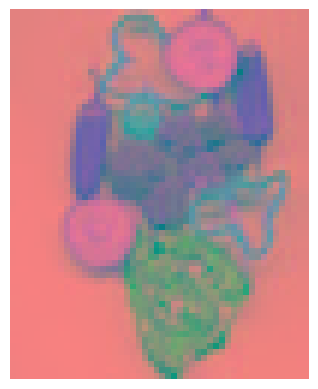

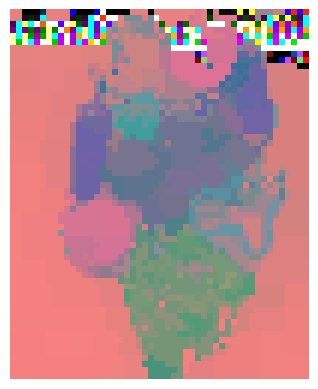

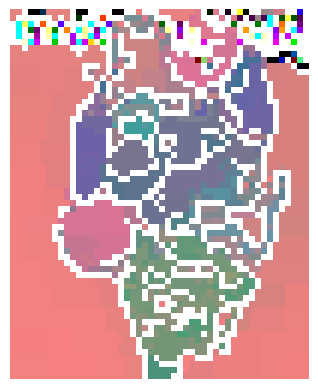

In [1214]:
ms_object = MeanShift(3,20,kernel="epanechnikov")
result, result_with_borders = ms_object.segment(segment_img)
# modes, labels = ms_object.mean_shift(xy, [])

# Replace the color values of the pixels associated with each mode by the color of the mode
segmented_img = np.zeros_like(img_lab)
for i, mode in enumerate(modes):
    mask = labels == i
    segmented_img[i] = mode[i]

def display_image(image):
    #plt.set_cmap('gray')
    plt.axis("off")
    plt.imshow(image)
    plt.show()

display_image(segment_img)
display_image(result)
display_image(result_with_borders)